## Import Relevant Files

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import R2Score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import math
import json
import csv

from IPython.display import Audio

import sys
sys.path.insert(1, '../utils')
from paths import *

sys.path.insert(1, '../models')
from feedforward_nn_combined import NeuralNetworkCombined
from pprint import pprint

import chromadb

## Load Music Metadata

In [2]:
ROOT_DIR = "../../"
DEAM_2013 = ROOT_DIR + DEAM_METADATA_2013
DEAM_2014 = ROOT_DIR + DEAM_METADATA_2014
PMEMO = ROOT_DIR + PMEMO_METADATA

In [3]:
df_music_pmemo = pd.read_csv(PMEMO)
df_music_pmemo = df_music_pmemo.drop(columns=["album", "duration",	"chorus_start_time", "chorus_end_time"])

display(df_music_pmemo)

musicId  fileName                                         title  \
0          1     1.mp3                                    Good Drank   
1          4     4.mp3                        X Bitch (feat. Future)   
2          5     5.mp3                                      No Heart   
3          6     6.mp3                                      Red Opps   
4          7     7.mp3                               Girls Talk Boys   
..       ...       ...                                           ...   
789      993   993.mp3                                          Stay   
790      996   996.mp3                                       Trouble   
791      997   997.mp3  A Supplementary Story : You Never Walk Alone   
792      999   999.mp3                                 Outro : Wings   
793     1000  1000.mp3                                    Spring Day   

                  artist  
0               2 Chainz  
1              21 Savage  
2              21 Savage  
3              21 Savage  
4    5 Seconds Of Summer  
..                   ...  
789                 Zedd  
790              offaiah  
791                방탄소년단  
792                방탄소년단  
793                방탄소년단  

[794 rows x 4 columns]

In [4]:
df_music_deam_2013 = pd.read_csv(DEAM_2013)
df_music_deam_2013 = df_music_deam_2013.drop(columns=["start of the segment (min.sec)", "end of the segment (min.sec)", "file_name", "Genre"])

display(df_music_deam_2013)

song_id                                    Artist  \
0          2            The New Mystikal Troubadours\t   
1          3                           Kevin MacLeod\t   
2          4                           Kevin MacLeod\t   
3          5                           My Bubba & Mi\t   
4          7                           Kevin MacLeod\t   
..       ...                                       ...   
739      995                           Benjamin Bret\t   
740      996                                 Jahzzar\t   
741      997                               Halloween\t   
742      999                                 Jahzzar\t   
743     1000  Republic Of Lights-Got You Surrounded \t   

                        Song title  
0    \tTonight  A Lonely Century\t  
1                    \tDD Groove\t  
2                    \tSlow Burn\t  
3                 \tNothing Much\t  
4                       \tHustle\t  
..                             ...  
739               \tHonte De Toi\t  
740                  \tFireworks\t  
741          \tMonster On Campus\t  
742                    \tSo Easy\t  
743                    \t Single\t  

[744 rows x 3 columns]

In [5]:
with open(DEAM_2014, newline="") as f:
    header = next(csv.reader(f))
    num_cols = len(next(csv.reader(f))) - len(header)

header += [f'last.fm_{i+1}' for i in range(num_cols)]
print(header)

df_music_deam_2014 = pd.read_csv(DEAM_2014, index_col=False, sep=",", skiprows=1, names=header)
display(df_music_deam_2014)

['Id', 'Artist', 'Album', 'Track', 'Genre', 'segment start', 'segment end', 'last.fm labels', 'last.fm_1', 'last.fm_2', 'last.fm_3', 'last.fm_4', 'last.fm_5', 'last.fm_6', 'last.fm_7', 'last.fm_8', 'last.fm_9', 'last.fm_10', 'last.fm_11', 'last.fm_12', 'last.fm_13', 'last.fm_14', 'last.fm_15', 'last.fm_16', 'last.fm_17', 'last.fm_18', 'last.fm_19', 'last.fm_20', 'last.fm_21', 'last.fm_22', 'last.fm_23', 'last.fm_24', 'last.fm_25', 'last.fm_26', 'last.fm_27', 'last.fm_28', 'last.fm_29', 'last.fm_30', 'last.fm_31', 'last.fm_32', 'last.fm_33', 'last.fm_34', 'last.fm_35', 'last.fm_36', 'last.fm_37', 'last.fm_38', 'last.fm_39', 'last.fm_40', 'last.fm_41', 'last.fm_42', 'last.fm_43', 'last.fm_44', 'last.fm_45', 'last.fm_46', 'last.fm_47', 'last.fm_48', 'last.fm_49', 'last.fm_50', 'last.fm_51', 'last.fm_52', 'last.fm_53', 'last.fm_54', 'last.fm_55', 'last.fm_56', 'last.fm_57', 'last.fm_58', 'last.fm_59', 'last.fm_60', 'last.fm_61', 'last.fm_62', 'last.fm_63', 'last.fm_64', 'last.fm_65', 'last

Id                              Artist  \
0    1001           The Rope River Blues Band   
1    1002  Kidney Brothers (The Numbers Band)   
2    1003                        Samm Bennett   
3    1004           The Rope River Blues Band   
4    1005                          Brother JT   
..    ...                                 ...   
995  1996                   The Matt Kurz One   
996  1997       Ariel Pink's Haunted Graffiti   
997  1998                     Fresh Body Shop   
998  1999                        The Gotobeds   
999  2000                     Fresh Body Shop   

                                                 Album  \
0                            Smith Enjoys a Full Bush.   
1    Live on WFMU's The John Allen Show - December ...   
2    Live on WFMU's Miniature Minotaurs with Kurt G...   
3                            The Rope River Blues Band   
4    Live on WFMU's Zzzzzzero Hour with Bill Mac - ...   
..                                                 ...   
995                              IF YOU CAN'T JOIN 'EM   
996                                       The Doldrums   
997                                      The Ugly Army   
998  Live on WFMU's Cherry Blossom Clinic with Terr...   
999                                      The Ugly Army   

                      Track                                            Genre  \
0                Weatherman  SoulRB-Country-Folk-Pop-Experimental-Rock-Blues   
1                      Wolf                                Blues-SoulRB-Rock   
2                  My My My                   Blues-SoulRB-Folk-Experimental   
3                   Visitor               SoulRB-Country-Folk-Pop-Rock-Blues   
4                    Summer                                Blues-SoulRB-Rock   
..                      ...                                              ...   
995                BEAT 'EM                                             Rock   
996         For Kate I Wait                                             Rock   
997       My Artificial Sun                                             Rock   
998               New Dress                                             Rock   
999  Never End Up Like This                                             Rock   

     segment start  segment end   last.fm labels       last.fm_1  \
0        12.034263   161.398617     experimental     Avant-Garde   
1       154.164422   207.191270       indie rock           indie   
2       112.003605   519.798617             jazz    tony bennett   
3         7.091270   442.450045            indie            rock   
4        56.198821   132.036984     classic rock           blues   
..             ...          ...              ...             ...   
995      98.239955   176.001066        Applicant          J-rock   
996      85.252426   259.828005            Lo-Fi           indie   
997     101.103038   165.594150             rock  french artists   
998       0.652812    46.355351            indie      indie rock   
999      78.063492   152.705986  brit indie rock            free   

           last.fm_2  ...      last.fm_91     last.fm_92  \
0         melancholy  ...             NaN            NaN   
1        alternative  ...          temazo      brit-rock   
2             oldies  ...       fH Projex     Sternmusik   
3        alternative  ...             NaN            NaN   
4       Janis Joplin  ...  nye favoritter  belles choses   
..               ...  ...             ...            ...   
995       visual kei  ...             NaN            NaN   
996     experimental  ...             NaN            NaN   
997  brit indie rock  ...             NaN            NaN   
998         Canadian  ...            glam          happy   
999     Electro-Rock  ...             NaN            NaN   

                 last.fm_93    last.fm_94             last.fm_95  \
0                       NaN           NaN                    NaN   
1    driver picks the music       gilbert  best songs of the 00s   
2               mo

In [6]:
df_music_deam_2014 = df_music_deam_2014[["Id", "Artist", "Track"]]
df_music_deam_2014.rename(columns={"Id": "song_id", "Track": "Song title"}, inplace=True)
df_music_deam = pd.concat([df_music_deam_2013, df_music_deam_2014], ignore_index=True)
display(df_music_deam)

song_id                          Artist                     Song title
0           2  The New Mystikal Troubadours\t  \tTonight  A Lonely Century\t
1           3                 Kevin MacLeod\t                  \tDD Groove\t
2           4                 Kevin MacLeod\t                  \tSlow Burn\t
3           5                 My Bubba & Mi\t               \tNothing Much\t
4           7                 Kevin MacLeod\t                     \tHustle\t
...       ...                             ...                            ...
1739     1996               The Matt Kurz One                       BEAT 'EM
1740     1997   Ariel Pink's Haunted Graffiti                For Kate I Wait
1741     1998                 Fresh Body Shop              My Artificial Sun
1742     1999                    The Gotobeds                      New Dress
1743     2000                 Fresh Body Shop         Never End Up Like This

[1744 rows x 3 columns]

In [7]:
def strip_values(value):
    value = value.strip()
    return value

In [8]:
df_music_deam_copy = df_music_deam.copy()

DEAM_AUDIO_DIR = ROOT_DIR + DEAM_AUDIO_FOLDER.replace("../", "")
df_music_deam_copy['file_path'] = df_music_deam_copy['song_id'].apply(lambda x: f'{DEAM_AUDIO_DIR}/{x}.mp3')
df_music_deam_copy['song_id'] = df_music_deam_copy['song_id'].apply(lambda x: f'deam_{x}')


df_music_deam_copy.rename(columns={"Artist": "artist", "Song title": "title"}, inplace=True)

cols = df_music_deam_copy.columns.tolist()

for col in cols:
    df_music_deam_copy[col] = df_music_deam_copy[col].map(strip_values)

display(df_music_deam_copy)

song_id                         artist                      title  \
0        deam_2   The New Mystikal Troubadours  Tonight  A Lonely Century   
1        deam_3                  Kevin MacLeod                  DD Groove   
2        deam_4                  Kevin MacLeod                  Slow Burn   
3        deam_5                  My Bubba & Mi               Nothing Much   
4        deam_7                  Kevin MacLeod                     Hustle   
...         ...                            ...                        ...   
1739  deam_1996              The Matt Kurz One                   BEAT 'EM   
1740  deam_1997  Ariel Pink's Haunted Graffiti            For Kate I Wait   
1741  deam_1998                Fresh Body Shop          My Artificial Sun   
1742  deam_1999                   The Gotobeds                  New Dress   
1743  deam_2000                Fresh Body Shop     Never End Up Like This   

                                file_path  
0        ../../data/DEAM/MEMD_audio/2.mp3  
1        ../../data/DEAM/MEMD_audio/3.mp3  
2        ../../data/DEAM/MEMD_audio/4.mp3  
3        ../../data/DEAM/MEMD_audio/5.mp3  
4        ../../data/DEAM/MEMD_audio/7.mp3  
...                                   ...  
1739  ../../data/DEAM/MEMD_audio/1996.mp3  
1740  ../../data/DEAM/MEMD_audio/1997.mp3  
1741  ../../data/DEAM/MEMD_audio/1998.mp3  
1742  ../../data/DEAM/MEMD_audio/1999.mp3  
1743  ../../data/DEAM/MEMD_audio/2000.mp3  

[1744 rows x 4 columns]

In [9]:
PMEMO_PROCESSED_STATIC_ANNOTATIONS = ROOT_DIR + PMEMO_PROCESSED_ANNOTATIONS_FOLDER.replace("../", "") + "/" + PMEMO_PROCESSED_STATIC_ANNOTATIONS_CSV
print(PMEMO_PROCESSED_STATIC_ANNOTATIONS)

df_pmemo_annotations = pd.read_csv(PMEMO_PROCESSED_STATIC_ANNOTATIONS)
pmemo_song_ids = df_pmemo_annotations['song_id'].tolist()
print(pmemo_song_ids)

../../data/PMEmo/PMEmo2019/processed/annotations/pmemo_static_annotations.csv
[1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 98, 99, 100, 102, 103, 104, 105, 106, 107, 108, 109, 113, 114, 115, 116, 117, 119, 120, 123, 124, 126, 127, 128, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 156, 157, 158, 159, 160, 161, 162, 165, 166, 167, 168, 169, 170, 171, 172, 174, 175, 176, 177, 179, 180, 181, 184, 185, 186, 187, 188, 189, 191, 192, 196, 197, 198, 199, 200, 201, 202, 203, 204, 207, 209, 210, 211, 212, 213, 215, 216, 217, 219, 220, 221, 222, 224, 225, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 241, 242, 244, 249, 251, 252, 253, 257, 258, 2

In [10]:
df_music_pmemo_copy = df_music_pmemo.copy()
df_music_pmemo_copy = df_music_pmemo_copy[df_music_pmemo_copy['musicId'].isin(pmemo_song_ids)]

PMEMO_AUDIO_DIR = ROOT_DIR + PMEMO_AUDIO_FOLDER.replace("../", "")
df_music_pmemo_copy['file_path'] = df_music_pmemo_copy['musicId'].apply(lambda x: f'{PMEMO_AUDIO_DIR}/{x}.mp3')
df_music_pmemo_copy['song_id'] = df_music_pmemo['musicId'].apply(lambda x: f'pmemo_{x}')
df_music_pmemo_copy = df_music_pmemo_copy.drop(columns=["musicId", "fileName"])

df_music_pmemo_copy = df_music_pmemo_copy[cols]
display(df_music_pmemo_copy)

song_id               artist  \
0       pmemo_1             2 Chainz   
1       pmemo_4            21 Savage   
2       pmemo_5            21 Savage   
3       pmemo_6            21 Savage   
4       pmemo_7  5 Seconds Of Summer   
..          ...                  ...   
789   pmemo_993                 Zedd   
790   pmemo_996              offaiah   
791   pmemo_997                방탄소년단   
792   pmemo_999                방탄소년단   
793  pmemo_1000                방탄소년단   

                                            title  \
0                                      Good Drank   
1                          X Bitch (feat. Future)   
2                                        No Heart   
3                                        Red Opps   
4                                 Girls Talk Boys   
..                                            ...   
789                                          Stay   
790                                       Trouble   
791  A Supplementary Story : You Never Walk Alone   
792                                 Outro : Wings   
793                                    Spring Day   

                                      file_path  
0       ../../data/PMEmo/PMEmo2019/chorus/1.mp3  
1       ../../data/PMEmo/PMEmo2019/chorus/4.mp3  
2       ../../data/PMEmo/PMEmo2019/chorus/5.mp3  
3       ../../data/PMEmo/PMEmo2019/chorus/6.mp3  
4       ../../data/PMEmo/PMEmo2019/chorus/7.mp3  
..                                          ...  
789   ../../data/PMEmo/PMEmo2019/chorus/993.mp3  
790   ../../data/PMEmo/PMEmo2019/chorus/996.mp3  
791   ../../data/PMEmo/PMEmo2019/chorus/997.mp3  
792   ../../data/PMEmo/PMEmo2019/chorus/999.mp3  
793  ../../data/PMEmo/PMEmo2019/chorus/1000.mp3  

[767 rows x 4 columns]

In [11]:
df_music = pd.concat([df_music_deam_copy, df_music_pmemo_copy], axis=0)

display(df_music)

song_id                        artist  \
0        deam_2  The New Mystikal Troubadours   
1        deam_3                 Kevin MacLeod   
2        deam_4                 Kevin MacLeod   
3        deam_5                 My Bubba & Mi   
4        deam_7                 Kevin MacLeod   
..          ...                           ...   
789   pmemo_993                          Zedd   
790   pmemo_996                       offaiah   
791   pmemo_997                         방탄소년단   
792   pmemo_999                         방탄소년단   
793  pmemo_1000                         방탄소년단   

                                            title  \
0                       Tonight  A Lonely Century   
1                                       DD Groove   
2                                       Slow Burn   
3                                    Nothing Much   
4                                          Hustle   
..                                            ...   
789                                          Stay   
790                                       Trouble   
791  A Supplementary Story : You Never Walk Alone   
792                                 Outro : Wings   
793                                    Spring Day   

                                      file_path  
0              ../../data/DEAM/MEMD_audio/2.mp3  
1              ../../data/DEAM/MEMD_audio/3.mp3  
2              ../../data/DEAM/MEMD_audio/4.mp3  
3              ../../data/DEAM/MEMD_audio/5.mp3  
4              ../../data/DEAM/MEMD_audio/7.mp3  
..                                          ...  
789   ../../data/PMEmo/PMEmo2019/chorus/993.mp3  
790   ../../data/PMEmo/PMEmo2019/chorus/996.mp3  
791   ../../data/PMEmo/PMEmo2019/chorus/997.mp3  
792   ../../data/PMEmo/PMEmo2019/chorus/999.mp3  
793  ../../data/PMEmo/PMEmo2019/chorus/1000.mp3  

[2511 rows x 4 columns]

## Load Opensmile Features

In [12]:
COMBINED_OPENSMILE_FEATURES = ROOT_DIR + COMBINED_EXTRACTED_FEATURES_FOLDER.replace("../", "") + "/" + OPENSMILE_GEMAPS_FEATURES_CSV

df_features = pd.read_csv(COMBINED_OPENSMILE_FEATURES)
display(df_features)

song_id  F0semitoneFrom27.5Hz_sma3nz_amean  \
0         deam_2                          22.932022   
1         deam_3                          16.164516   
2         deam_4                          22.580710   
3         deam_5                          29.905169   
4         deam_7                          18.706436   
...          ...                                ...   
2506   pmemo_993                          28.589037   
2507   pmemo_996                          34.963680   
2508   pmemo_997                          23.521826   
2509   pmemo_999                          28.412848   
2510  pmemo_1000                          28.422981   

      F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
0                                   0.189338   
1                                   0.178617   
2                                   0.329062   
3                                   0.264543   
4                                   0.172212   
...                                      ...   
2506                                0.445477   
2507                                0.308940   
2508                                0.515144   
2509                                0.529474   
2510                                0.465772   

      F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
0                                      19.655570   
1                                      14.101058   
2                                      16.054005   
3                                      22.387814   
4                                      15.197102   
...                                          ...   
2506                                   16.152197   
2507                                   23.050102   
2508                                   13.664935   
2509                                   14.129504   
2510                                   14.124825   

      F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
0                                      23.607199   
1                                      15.239481   
2                                      23.823282   
3                                      30.137478   
4                                      18.928482   
...                                          ...   
2506                                   24.940647   
2507                                   39.976578   
2508                                   16.773577   
2509                                   21.055300   
2510                                   23.073471   

      F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
0                                      24.485361   
1                                      18.985416   
2                                      24.116590   
3                                      37.959970   
4                                      21.956436   
...                                          ...   
2506                                   44.368267   
2507                                   43.117737   
2508                                   37.080620   
2509                                   48.873077   
2510                                   44.002636   

      F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2  \
0                                     4.829792   
1                                     4.884358   
2                                     8.062586   
3                                    15.572155   
4                                     6.759335   
...                                        ...   
2506                                 28.216070   
2507                                 20.067635   
2508                                 23.415684   
2509                                 34.743572   
2510                                 29.877811   

      F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope  \
0                                      124.252335   
1                                       85.965515   
2                                      299.053960   
3                                      179.485930   
4                             

In [13]:
df_combined = df_music.merge(df_features, how="inner", on="song_id")
display(df_combined)

song_id                        artist  \
0         deam_2  The New Mystikal Troubadours   
1         deam_3                 Kevin MacLeod   
2         deam_4                 Kevin MacLeod   
3         deam_5                 My Bubba & Mi   
4         deam_7                 Kevin MacLeod   
...          ...                           ...   
2506   pmemo_993                          Zedd   
2507   pmemo_996                       offaiah   
2508   pmemo_997                         방탄소년단   
2509   pmemo_999                         방탄소년단   
2510  pmemo_1000                         방탄소년단   

                                             title  \
0                        Tonight  A Lonely Century   
1                                        DD Groove   
2                                        Slow Burn   
3                                     Nothing Much   
4                                           Hustle   
...                                            ...   
2506                                          Stay   
2507                                       Trouble   
2508  A Supplementary Story : You Never Walk Alone   
2509                                 Outro : Wings   
2510                                    Spring Day   

                                       file_path  \
0               ../../data/DEAM/MEMD_audio/2.mp3   
1               ../../data/DEAM/MEMD_audio/3.mp3   
2               ../../data/DEAM/MEMD_audio/4.mp3   
3               ../../data/DEAM/MEMD_audio/5.mp3   
4               ../../data/DEAM/MEMD_audio/7.mp3   
...                                          ...   
2506   ../../data/PMEmo/PMEmo2019/chorus/993.mp3   
2507   ../../data/PMEmo/PMEmo2019/chorus/996.mp3   
2508   ../../data/PMEmo/PMEmo2019/chorus/997.mp3   
2509   ../../data/PMEmo/PMEmo2019/chorus/999.mp3   
2510  ../../data/PMEmo/PMEmo2019/chorus/1000.mp3   

      F0semitoneFrom27.5Hz_sma3nz_amean  \
0                             22.932022   
1                             16.164516   
2                             22.580710   
3                             29.905169   
4                             18.706436   
...                                 ...   
2506                          28.589037   
2507                          34.963680   
2508                          23.521826   
2509                          28.412848   
2510                          28.422981   

      F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
0                                   0.189338   
1                                   0.178617   
2                                   0.329062   
3                                   0.264543   
4                                   0.172212   
...                                      ...   
2506                                0.445477   
2507                                0.308940   
2508                                0.515144   
2509                                0.529474   
2510                                0.465772   

      F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
0                                      19.655570   
1                                      14.101058   
2                                      16.054005   
3                                      22.387814   
4                                      15.197102   
...                                          ...   
2506                                   16.152197   
2507                                   23.050102   
2508                                   13.664935   
2509                                   14.129504   
2510                                   14.124825   

      F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
0                                      23.607199   
1                                      15.239481   
2                                      23.823282   
3                                      30.137478   
4                                      18.928482   
...                                          ...   
2506                                   24.940647   

In [14]:
with open("../models/opensmile_gemaps_normalised/config.json") as file:
    config = json.load(file)

In [15]:
pprint(config)

{'columns': ['F0semitoneFrom27.5Hz_sma3nz_amean',
             'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
             'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
             'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
             'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
             'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
             'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
             'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
             'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
             'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope',
             'loudness_sma3_amean',
             'loudness_sma3_stddevNorm',
             'loudness_sma3_percentile20.0',
             'loudness_sma3_percentile50.0',
             'loudness_sma3_percentile80.0',
             'loudness_sma3_pctlrange0-2',
             'loudness_sma3_meanRisingSlope',
             'loudness_sma3_stddevRisingSlope',
             'loudness_sma3_meanFallingSlope',
             'loudn

In [16]:
feature_cols = config["columns"]

pprint(feature_cols)

['F0semitoneFrom27.5Hz_sma3nz_amean',
 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope',
 'loudness_sma3_amean',
 'loudness_sma3_stddevNorm',
 'loudness_sma3_percentile20.0',
 'loudness_sma3_percentile50.0',
 'loudness_sma3_percentile80.0',
 'loudness_sma3_pctlrange0-2',
 'loudness_sma3_meanRisingSlope',
 'loudness_sma3_stddevRisingSlope',
 'loudness_sma3_meanFallingSlope',
 'loudness_sma3_stddevFallingSlope',
 'jitterLocal_sma3nz_amean',
 'jitterLocal_sma3nz_stddevNorm',
 'shimmerLocaldB_sma3nz_amean',
 'shimmerLocaldB_sma3nz_stddevNorm',
 'HNRdBACF_sma3nz_amean',
 'HNRdBACF_sma3nz_stddevNorm',
 'logRelF0-H1-H2_sma3

In [17]:
scaler_fpath = config["scaler"]
# print(scaler_fpath)
scaler_fpath = scaler_fpath.replace(".", "../..", 1)
scaler = joblib.load(scaler_fpath) #MinMaxScaler

In [18]:
input_size = len(config["columns"])
print(input_size)
weights_fpath = config["model_weights"]
weights_fpath = weights_fpath.replace(".", "../..", 1)

model = NeuralNetworkCombined(input_size)
model.load_state_dict(torch.load(weights_fpath))

62


<All keys matched successfully>

In [19]:
inputs_normalised = scaler.transform(df_combined[config["columns"]].values)
inputs = torch.tensor(inputs_normalised).float()
print(inputs)

tensor([[0.2031, 0.2290, 0.1763,  ..., 0.1645, 0.0263, 0.0142],
        [0.0456, 0.2126, 0.0472,  ..., 0.0244, 0.0741, 0.0568],
        [0.1949, 0.4419, 0.0926,  ..., 0.0186, 0.0389, 0.0180],
        ...,
        [0.2169, 0.7255, 0.0370,  ..., 0.0141, 0.0801, 0.1361],
        [0.3307, 0.7473, 0.0478,  ..., 0.0133, 0.0998, 0.2008],
        [0.3309, 0.6502, 0.0477,  ..., 0.0098, 0.1009, 0.1005]])


/Users/issacj/Desktop/Personal/SUTD/School Year/Year 3/Term 6/50.038 Computational Data Science/Project/CDeeS/env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [20]:
preds = model(inputs)
print(preds)

tensor([[-0.0734, -0.1276],
        [-0.2044, -0.0619],
        [ 0.2093,  0.2068],
        ...,
        [ 0.2965,  0.4219],
        [ 0.6122,  0.7555],
        [ 0.5335,  0.6505]], grad_fn=<TanhBackward0>)


In [21]:
# Pretend to keep only VA values - Used dummy variables instead
df_combined["valence_pred"] = preds[:, 0].detach().numpy()
df_combined["arousal_pred"] = preds[:, 1].detach().numpy()
display(df_combined)

song_id                        artist  \
0         deam_2  The New Mystikal Troubadours   
1         deam_3                 Kevin MacLeod   
2         deam_4                 Kevin MacLeod   
3         deam_5                 My Bubba & Mi   
4         deam_7                 Kevin MacLeod   
...          ...                           ...   
2506   pmemo_993                          Zedd   
2507   pmemo_996                       offaiah   
2508   pmemo_997                         방탄소년단   
2509   pmemo_999                         방탄소년단   
2510  pmemo_1000                         방탄소년단   

                                             title  \
0                        Tonight  A Lonely Century   
1                                        DD Groove   
2                                        Slow Burn   
3                                     Nothing Much   
4                                           Hustle   
...                                            ...   
2506                                          Stay   
2507                                       Trouble   
2508  A Supplementary Story : You Never Walk Alone   
2509                                 Outro : Wings   
2510                                    Spring Day   

                                       file_path  \
0               ../../data/DEAM/MEMD_audio/2.mp3   
1               ../../data/DEAM/MEMD_audio/3.mp3   
2               ../../data/DEAM/MEMD_audio/4.mp3   
3               ../../data/DEAM/MEMD_audio/5.mp3   
4               ../../data/DEAM/MEMD_audio/7.mp3   
...                                          ...   
2506   ../../data/PMEmo/PMEmo2019/chorus/993.mp3   
2507   ../../data/PMEmo/PMEmo2019/chorus/996.mp3   
2508   ../../data/PMEmo/PMEmo2019/chorus/997.mp3   
2509   ../../data/PMEmo/PMEmo2019/chorus/999.mp3   
2510  ../../data/PMEmo/PMEmo2019/chorus/1000.mp3   

      F0semitoneFrom27.5Hz_sma3nz_amean  \
0                             22.932022   
1                             16.164516   
2                             22.580710   
3                             29.905169   
4                             18.706436   
...                                 ...   
2506                          28.589037   
2507                          34.963680   
2508                          23.521826   
2509                          28.412848   
2510                          28.422981   

      F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
0                                   0.189338   
1                                   0.178617   
2                                   0.329062   
3                                   0.264543   
4                                   0.172212   
...                                      ...   
2506                                0.445477   
2507                                0.308940   
2508                                0.515144   
2509                                0.529474   
2510                                0.465772   

      F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
0                                      19.655570   
1                                      14.101058   
2                                      16.054005   
3                                      22.387814   
4                                      15.197102   
...                                          ...   
2506                                   16.152197   
2507                                   23.050102   
2508                                   13.664935   
2509                                   14.129504   
2510                                   14.124825   

      F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
0                                      23.607199   
1                                      15.239481   
2                                      23.823282   
3                                      30.137478   
4                                      18.928482   
...                                          ...   
2506                                   24.940647   

In [22]:
df_va = df_combined[["valence_pred", "arousal_pred"]].copy()
display(df_va.values.tolist())

[[-0.07338837534189224, -0.1276376098394394],
 [-0.20439529418945312, -0.06186279281973839],
 [0.20931197702884674, 0.20675651729106903],
 [0.06673110276460648, -0.21515502035617828],
 [0.07614307850599289, 0.2650906443595886],
 [-0.16405338048934937, -0.22950097918510437],
 [-0.18361538648605347, -0.25756338238716125],
 [0.22818326950073242, 0.2879182696342468],
 [-0.21645154058933258, -0.3381359279155731],
 [0.18282552063465118, 0.2547813653945923],
 [-0.1677337884902954, -0.14065274596214294],
 [-0.01641395315527916, -0.2541503608226776],
 [0.28933224081993103, 0.2588631510734558],
 [0.16527754068374634, 0.2465427666902542],
 [-0.027322731912136078, -0.017884299159049988],
 [0.03422003239393234, 0.10198088735342026],
 [0.17148429155349731, 0.036778826266527176],
 [0.13872088491916656, 0.11351993680000305],
 [0.044606007635593414, -0.07449808716773987],
 [0.07592610269784927, 0.23364867269992828],
 [0.20255620777606964, 0.000177726149559021],
 [0.3322659432888031, 0.33017751574516296

In [23]:
def color_quadrants(row):
    if row.loc["valence_pred"] >= 0 and row.loc["arousal_pred"] >= 0:
        return 1
    elif row.loc["valence_pred"] < 0 and row.loc["arousal_pred"] >= 0:
        return 2
    elif row.loc["valence_pred"] < 0 and row.loc["arousal_pred"] < 0:
        return 3
    elif row.loc["valence_pred"] >= 0 and row.loc["arousal_pred"] < 0:
        return 4

df_va["quadrant"] = df_va.apply(color_quadrants, axis=1)

display(df_va)

valence_pred  arousal_pred  quadrant
0        -0.073388     -0.127638         3
1        -0.204395     -0.061863         3
2         0.209312      0.206757         1
3         0.066731     -0.215155         4
4         0.076143      0.265091         1
...            ...           ...       ...
2506      0.253164      0.352882         1
2507      0.409169      0.504471         1
2508      0.296542      0.421905         1
2509      0.612219      0.755452         1
2510      0.533498      0.650507         1

[2511 rows x 3 columns]

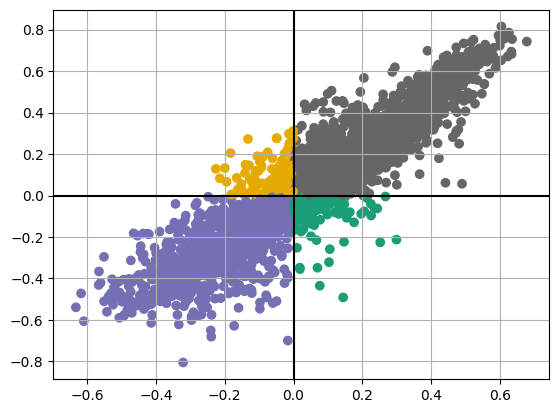

In [24]:
plt.scatter(df_va["valence_pred"], df_va["arousal_pred"], c=df_va["quadrant"], cmap="Dark2_r")
plt.axhline(y=0, linestyle='-', color='k') # horizontal lines
plt.axvline(x=0, linestyle='-', color='k')
plt.grid(True)
plt.show()

In [25]:
embeddings_list = df_va[["valence_pred", "arousal_pred"]].values.tolist()

In [26]:
metadata = df_combined.columns.tolist()[1:3]
metadata_dicts = df_combined[metadata].to_dict('records')
pprint(metadata_dicts)

[{'artist': 'The New Mystikal Troubadours',
  'title': 'Tonight  A Lonely Century'},
 {'artist': 'Kevin MacLeod', 'title': 'DD Groove'},
 {'artist': 'Kevin MacLeod', 'title': 'Slow Burn'},
 {'artist': 'My Bubba & Mi', 'title': 'Nothing Much'},
 {'artist': 'Kevin MacLeod', 'title': 'Hustle'},
 {'artist': 'Kevin MacLeod', 'title': 'Dirt Rhodes'},
 {'artist': 'Arne Bang Huseby', 'title': 'Stormy Blues'},
 {'artist': 'Sul Rebel', 'title': 'Rebel Blues'},
 {'artist': 'My Bubba & Mi', 'title': 'Oh Kiss No'},
 {'artist': 'Phoephus', 'title': 'Fjcb Reddit Gtr Fills Mix'},
 {'artist': 'Black Rebel Motorcycle Club',
  'title': "Beat The Devil's Tattoo (Live @ KEXP)"},
 {'artist': "WHO'S PANDA", 'title': 'Vultures'},
 {'artist': "Stevie's Amp Shack",
  'title': 'Blues Shuffle in A One Take Improv Exercise'},
 {'artist': 'Cian Nugent', 'title': 'My War Blues'},
 {'artist': 'The New Mystikal Troubadours', 'title': 'The Holy Feele'},
 {'artist': 'Bombay Laughing Club', 'title': 'Workin Boy Blues'},


In [27]:
song_ids = df_combined["song_id"].values.tolist()
print(song_ids)

['deam_2', 'deam_3', 'deam_4', 'deam_5', 'deam_7', 'deam_8', 'deam_10', 'deam_12', 'deam_13', 'deam_17', 'deam_18', 'deam_19', 'deam_20', 'deam_21', 'deam_22', 'deam_24', 'deam_25', 'deam_31', 'deam_32', 'deam_35', 'deam_37', 'deam_39', 'deam_40', 'deam_41', 'deam_42', 'deam_43', 'deam_44', 'deam_45', 'deam_46', 'deam_47', 'deam_48', 'deam_49', 'deam_50', 'deam_51', 'deam_52', 'deam_53', 'deam_54', 'deam_55', 'deam_56', 'deam_58', 'deam_59', 'deam_60', 'deam_62', 'deam_64', 'deam_65', 'deam_67', 'deam_68', 'deam_69', 'deam_70', 'deam_71', 'deam_72', 'deam_73', 'deam_74', 'deam_76', 'deam_77', 'deam_78', 'deam_79', 'deam_80', 'deam_81', 'deam_82', 'deam_83', 'deam_84', 'deam_85', 'deam_86', 'deam_87', 'deam_88', 'deam_89', 'deam_90', 'deam_91', 'deam_92', 'deam_93', 'deam_95', 'deam_96', 'deam_98', 'deam_99', 'deam_101', 'deam_102', 'deam_103', 'deam_104', 'deam_105', 'deam_106', 'deam_107', 'deam_108', 'deam_109', 'deam_110', 'deam_111', 'deam_112', 'deam_113', 'deam_114', 'deam_115', 

In [28]:
fpath_list = df_combined["file_path"].values.tolist()

## Chroma Vector Database

In [29]:
# client = chromadb.Client()

## Persistent store
client = chromadb.PersistentClient(path="./db")

client.heartbeat()


1712983423882838000

In [30]:
# https://docs.trychroma.com/usage-guide#changing-the-distance-function
collection = client.create_collection(
        name="DEAM_PMEmo_dataset",
        metadata={"hnsw:space": "l2"} # "l2", "ip" or "cosine"
    )

In [31]:
collection.add(
    documents=fpath_list, # file_path
    embeddings=embeddings_list, # VA embeddings
    metadatas=metadata_dicts, # song_names, artist
    ids=song_ids # song_id from SiTunes dataset
)

In [32]:
# Set number of results to return
k = 5

In [33]:
res = collection.query(
    query_embeddings=[[1, 1]], # search by embeddings
    n_results=k, # number of results
    # where={"metadata_field": "is_equal_to_this"}, # filter on metadata, e.g. genre
    # where_document={"$contains":"search_string"} # filter on file path???
    # include=["distances", "metadatas", "embeddings", "documents", "uris", "data"] # Need to include all relevant parameters to show
    include=["distances", "metadatas", "embeddings", "documents"]
    )

pprint(res)

metadata = res["metadatas"][0][0]
fpath = res["documents"][0][0]
print(metadata, fpath)

Audio(fpath)

{'data': None,
 'distances': [[0.16964653134346008,
                0.1852930337190628,
                0.1904083490371704,
                0.19308459758758545,
                0.20615731179714203]],
 'documents': [['../../data/PMEmo/PMEmo2019/chorus/567.mp3',
                '../../data/PMEmo/PMEmo2019/chorus/171.mp3',
                '../../data/PMEmo/PMEmo2019/chorus/379.mp3',
                '../../data/PMEmo/PMEmo2019/chorus/39.mp3',
                '../../data/PMEmo/PMEmo2019/chorus/489.mp3']],
 'embeddings': [[[0.678508996963501, 0.742531418800354],
                 [0.6265267729759216, 0.7859654426574707],
                 [0.6046344637870789, 0.8153532147407532],
                 [0.6356500387191772, 0.7543708086013794],
                 [0.602489173412323, 0.7805861234664917]]],
 'ids': [['pmemo_567', 'pmemo_171', 'pmemo_379', 'pmemo_39', 'pmemo_489']],
 'metadatas': [[{'artist': 'Lady GaGa', 'title': 'Applause'},
                {'artist': 'Craig David', 'title': "Ain't Givi

In [34]:
res = collection.query(
    query_embeddings=[[-1, -1]], # search by embeddings
    n_results=k, # number of results
    include=["distances", "metadatas", "embeddings", "documents"]
)

pprint(res)

metadata = res["metadatas"][0][0]
fpath = res["documents"][0][0]
print(metadata, fpath)

Audio(fpath)

{'data': None,
 'distances': [[0.30747127532958984,
                0.34710875153541565,
                0.40203315019607544,
                0.4119747281074524,
                0.42488574981689453]],
 'documents': [['../../data/DEAM/MEMD_audio/1171.mp3',
                '../../data/DEAM/MEMD_audio/1332.mp3',
                '../../data/DEAM/MEMD_audio/945.mp3',
                '../../data/DEAM/MEMD_audio/1135.mp3',
                '../../data/DEAM/MEMD_audio/171.mp3']],
 'embeddings': [[[-0.6098222732543945, -0.6060042977333069],
                 [-0.6328911185264587, -0.5391965508460999],
                 [-0.5425667762756348, -0.56092369556427],
                 [-0.5066089630126953, -0.5894637703895569],
                 [-0.6178457736968994, -0.4719432592391968]]],
 'ids': [['deam_1171', 'deam_1332', 'deam_945', 'deam_1135', 'deam_171']],
 'metadatas': [[{'artist': 'Podington Bear', 'title': 'Crow'},
                {'artist': 'Illusion of Safety', 'title': 'Wasteland'},
         

In [35]:
res = collection.query(
    query_embeddings=[[-1, 1]], # search by embeddings
    n_results=k, # number of results
    include=["distances", "metadatas", "embeddings", "documents"]
)

pprint(res)

metadata = res["metadatas"][0][0]
fpath = res["documents"][0][0]
print(metadata, fpath)

Audio(fpath)

{'data': None,
 'distances': [[1.2814199924468994,
                1.2999112606048584,
                1.358677864074707,
                1.3787089586257935,
                1.3927717208862305]],
 'documents': [['../../data/DEAM/MEMD_audio/1921.mp3',
                '../../data/PMEmo/PMEmo2019/chorus/253.mp3',
                '../../data/PMEmo/PMEmo2019/chorus/962.mp3',
                '../../data/DEAM/MEMD_audio/1955.mp3',
                '../../data/DEAM/MEMD_audio/333.mp3']],
 'embeddings': [[[-0.1325073540210724, 0.2727610468864441],
                 [-0.18302376568317413, 0.20472575724124908],
                 [-0.22595670819282532, 0.12848711013793945],
                 [0.03230869397521019, 0.44049328565597534],
                 [-0.19964022934436798, 0.13270771503448486]]],
 'ids': [['deam_1921', 'pmemo_253', 'pmemo_962', 'deam_1955', 'deam_333']],
 'metadatas': [[{'artist': 'No Class', 'title': 'Let Down'},
                {'artist': 'Drake', 'title': 'Free Smoke'},
          

In [36]:
res = collection.query(
    query_embeddings=[[1, -1]], # search by embeddings
    n_results=k, # number of results
    include=["distances", "metadatas", "embeddings", "documents"]
)

pprint(res)

metadata = res["metadatas"][0][1]
fpath = res["documents"][0][1]
print(metadata, fpath)

Audio(fpath)

{'data': None,
 'distances': [[0.9905972480773926,
                1.1106339693069458,
                1.1235756874084473,
                1.1587066650390625,
                1.1722248792648315]],
 'documents': [['../../data/DEAM/MEMD_audio/456.mp3',
                '../../data/DEAM/MEMD_audio/977.mp3',
                '../../data/DEAM/MEMD_audio/1719.mp3',
                '../../data/DEAM/MEMD_audio/45.mp3',
                '../../data/DEAM/MEMD_audio/1261.mp3']],
 'embeddings': [[[0.14440837502479553, -0.49151188135147095],
                 [0.2994464635848999, -0.21268893778324127],
                 [-0.01652107946574688, -0.6995661854743958],
                 [0.2522721290588379, -0.22565536201000214],
                 [0.07641205936670303, -0.435013085603714]]],
 'ids': [['deam_456', 'deam_977', 'deam_1719', 'deam_45', 'deam_1261']],
 'metadatas': [[{'artist': 'Stickfigure', 'title': 'Crack in Time'},
                {'artist': 'Black Math', 'title': 'Suck City'},
                

In [37]:
res = collection.query(
    query_embeddings=[[0, 0]], # search by embeddings
    n_results=k, # number of results
    include=["distances", "metadatas", "embeddings", "documents"]
)

pprint(res)

metadata = res["metadatas"][0][0]
fpath = res["documents"][0][0]
print(metadata, fpath)

Audio(fpath)

{'data': None,
 'distances': [[4.0376497054239735e-05,
                4.96424145239871e-05,
                5.171115481061861e-05,
                9.833698277361691e-05,
                0.00010919326450675726]],
 'documents': [['../../data/DEAM/MEMD_audio/1489.mp3',
                '../../data/DEAM/MEMD_audio/582.mp3',
                '../../data/DEAM/MEMD_audio/1425.mp3',
                '../../data/DEAM/MEMD_audio/1566.mp3',
                '../../data/DEAM/MEMD_audio/1031.mp3']],
 'embeddings': [[[-0.002057545818388462, 0.006011905148625374],
                 [-0.0068814014084637165, 0.0015128541272133589],
                 [-0.006801603827625513, -0.0023343819193542004],
                 [-0.009660178795456886, 0.002240072935819626],
                 [0.008316904306411743, 0.0063263229094445705]]],
 'ids': [['deam_1489', 'deam_582', 'deam_1425', 'deam_1566', 'deam_1031']],
 'metadatas': [[{'artist': 'John Wicks and Paul Collins',
                 'title': 'Rock and Roll Girl'},
  